Data pre-processing

In [1]:
import pandas as pd
import os
import zipfile

In [2]:
zip_path = "/mnt/data/raw.zip"
extract_path = "/mnt/data/olist_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
base_path = extract_path
orders = pd.read_csv(os.path.join(base_path, "olist_orders_dataset.csv"))
customers = pd.read_csv(os.path.join(base_path, "olist_customers_dataset.csv"))
payments = pd.read_csv(os.path.join(base_path, "olist_order_payments_dataset.csv"))
order_items = pd.read_csv(os.path.join(base_path, "olist_order_items_dataset.csv"))
products = pd.read_csv(os.path.join(base_path, "olist_products_dataset.csv"))

In [4]:
# Step-by-step merge to create the cleaned master dataset

orders_customers = orders.merge(customers, on="customer_id", how="left")
orders_payments = orders_customers.merge(payments, on="order_id", how="left")
orders_items = orders_payments.merge(order_items, on="order_id", how="left")
orders_full = orders_items.merge(products, on="product_id", how="left")
orders_full = orders_full[orders_full["order_status"] == "delivered"]
date_cols = [
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date", "shipping_limit_date"
]
for col in date_cols:
    if col in orders_full.columns:
        orders_full[col] = pd.to_datetime(orders_full[col], errors="coerce")

In [5]:
#Create calculated delivery metrics
orders_full["delivery_time_days"] = (
    orders_full["order_delivered_customer_date"] - orders_full["order_purchase_timestamp"]
).dt.days

orders_full["shipping_delay_days"] = (
    orders_full["order_delivered_customer_date"] - orders_full["order_delivered_carrier_date"]
).dt.days

In [6]:
#Final cleaned dataset
orders_cleaned = orders_full.copy()

In [7]:
orders_cleaned.shape, orders_cleaned[['order_id', 'payment_value', 'price', 'freight_value', 'delivery_time_days']].head()

((115038, 32),
                            order_id  payment_value   price  freight_value  \
 0  e481f51cbdc54678b7cc49136f2d6af7          18.12   29.99           8.72   
 1  e481f51cbdc54678b7cc49136f2d6af7           2.00   29.99           8.72   
 2  e481f51cbdc54678b7cc49136f2d6af7          18.59   29.99           8.72   
 3  53cdb2fc8bc7dce0b6741e2150273451         141.46  118.70          22.76   
 4  47770eb9100c2d0c44946d9cf07ec65d         179.12  159.90          19.22   
 
    delivery_time_days  
 0                 8.0  
 1                 8.0  
 2                 8.0  
 3                13.0  
 4                 9.0  )

EDA

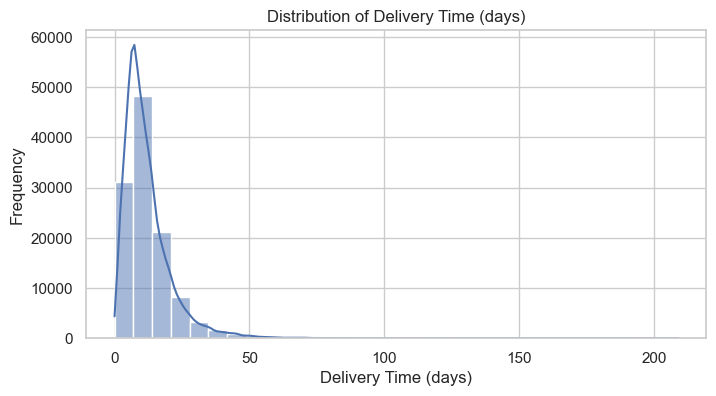

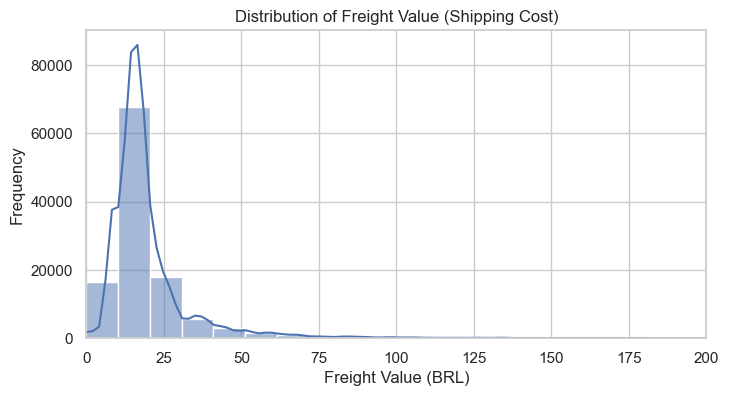

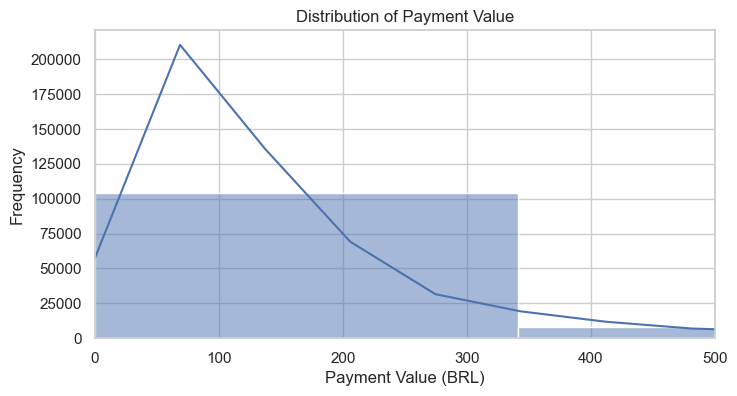

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Plot 1: Distribution of delivery time
plt.figure(figsize=(8, 4))
sns.histplot(orders_cleaned["delivery_time_days"].dropna(), bins=30, kde=True)
plt.title("Distribution of Delivery Time (days)")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Distribution of freight value (shipping cost)
plt.figure(figsize=(8, 4))
sns.histplot(orders_cleaned["freight_value"], bins=40, kde=True)
plt.title("Distribution of Freight Value (Shipping Cost)")
plt.xlabel("Freight Value (BRL)")
plt.xlim(0, 200)
plt.ylabel("Frequency")
plt.show()

# Plot 3: Distribution of payment value
plt.figure(figsize=(8, 4))
sns.histplot(orders_cleaned["payment_value"], bins=40, kde=True)
plt.title("Distribution of Payment Value")
plt.xlabel("Payment Value (BRL)")
plt.xlim(0, 500)
plt.ylabel("Frequency")
plt.show()

In [9]:
#missing values
missing_summary = orders_cleaned.isnull().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]


In [10]:
missing_summary

product_photos_qty               1628
product_category_name            1628
product_name_lenght              1628
product_description_lenght       1628
product_weight_g                   20
product_width_cm                   20
product_height_cm                  20
product_length_cm                  20
order_approved_at                  15
shipping_delay_days                 9
order_delivered_customer_date       8
delivery_time_days                  8
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
order_delivered_carrier_date        2
dtype: int64

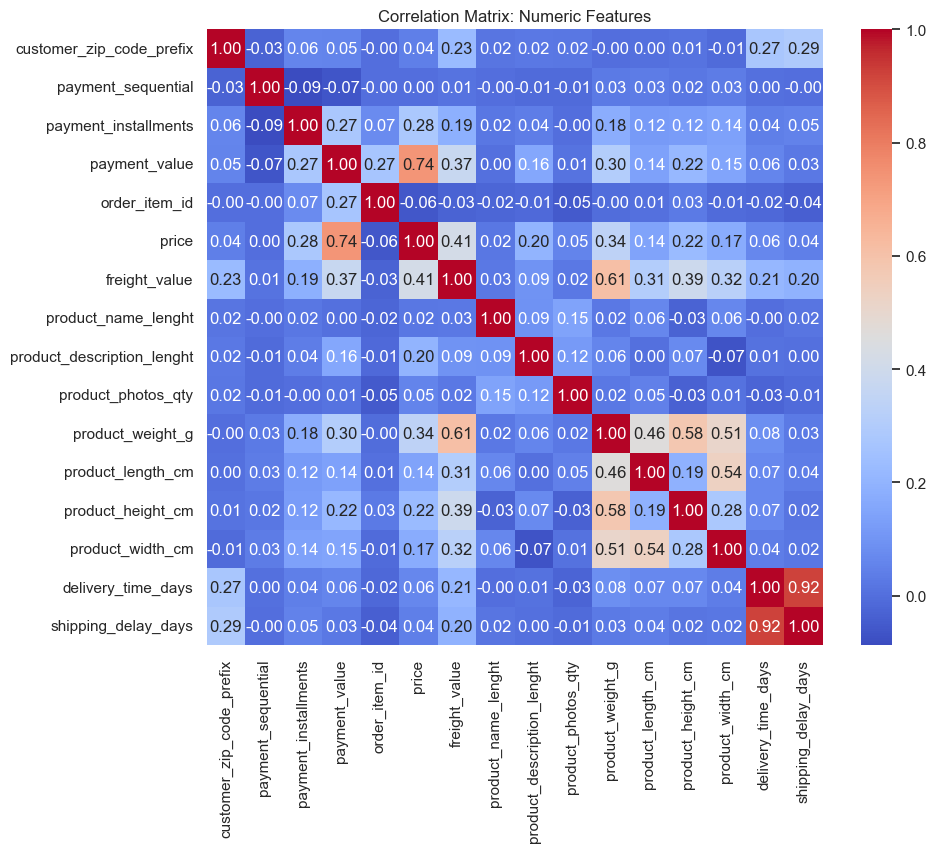

In [11]:
numeric_cols = orders_cleaned.select_dtypes(include='number')
correlation_matrix = numeric_cols.corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix: Numeric Features")
plt.show()

In [12]:
category_translation = pd.read_csv(os.path.join(base_path, "product_category_name_translation.csv"))

#Merge product categories into the cleaned dataset
orders_cleaned = orders_cleaned.merge(
    category_translation, how='left', on='product_category_name'
)

C:\Users\Vaishnavi J\AppData\Local\Temp\ipykernel_27356\3610486367.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_revenue, x="total_revenue", y="product_category_name_english", palette="viridis")


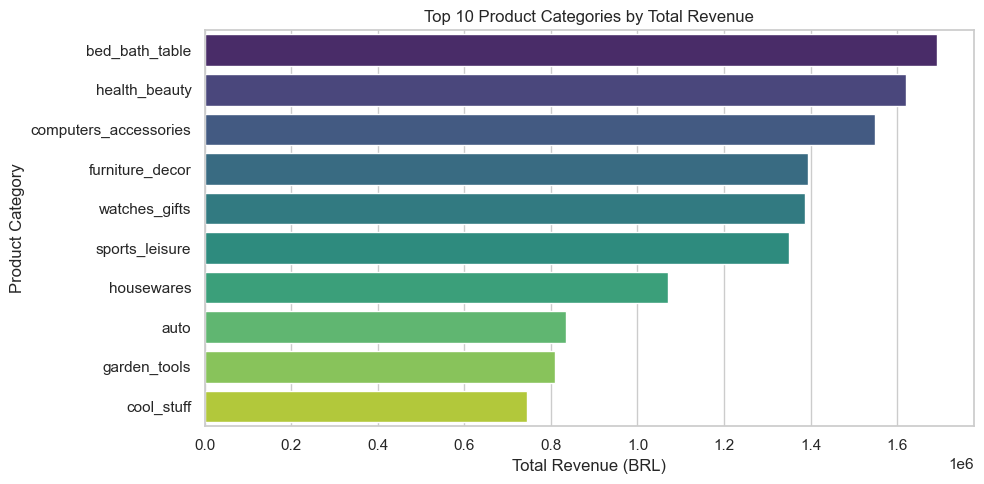

C:\Users\Vaishnavi J\AppData\Local\Temp\ipykernel_27356\3610486367.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seller_freight, x="total_freight", y="seller_id", palette="magma")


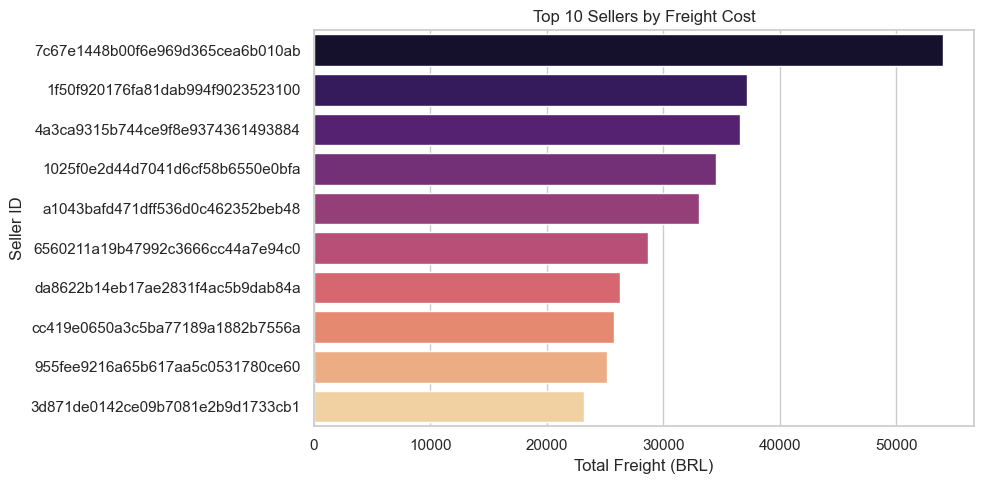

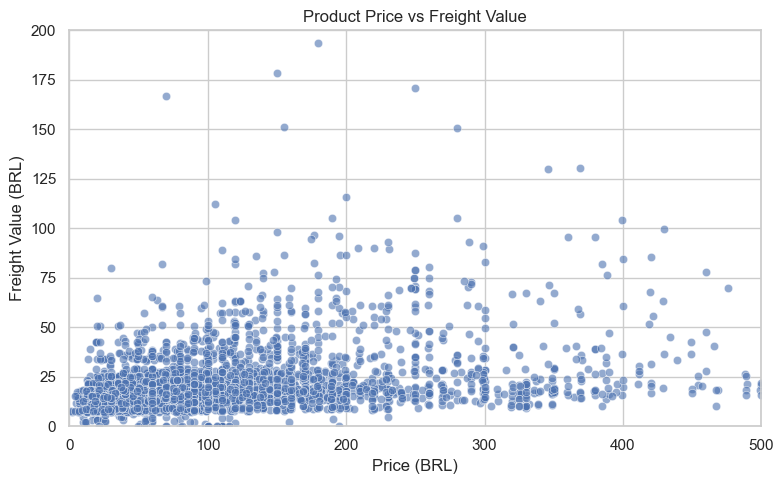

In [13]:
# 1. Top 10 product categories by total revenue
category_revenue = (
    orders_cleaned.groupby("product_category_name_english")
    .agg(total_revenue=('payment_value', 'sum'))
    .sort_values(by="total_revenue", ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=category_revenue, x="total_revenue", y="product_category_name_english", palette="viridis")
plt.title("Top 10 Product Categories by Total Revenue")
plt.xlabel("Total Revenue (BRL)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

# 2. Top 10 sellers by total freight cost
seller_freight = (
    orders_cleaned.groupby("seller_id")
    .agg(total_freight=('freight_value', 'sum'))
    .sort_values(by="total_freight", ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=seller_freight, x="total_freight", y="seller_id", palette="magma")
plt.title("Top 10 Sellers by Freight Cost")
plt.xlabel("Total Freight (BRL)")
plt.ylabel("Seller ID")
plt.tight_layout()
plt.show()

# 3. Scatterplot: Price vs Freight Value
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=orders_cleaned.sample(5000, random_state=42),
    x="price", y="freight_value", alpha=0.6
)
plt.title("Product Price vs Freight Value")
plt.xlabel("Price (BRL)")
plt.ylabel("Freight Value (BRL)")
plt.xlim(0, 500)
plt.ylim(0, 200)
plt.tight_layout()
plt.show()

In [15]:
orders_cleaned.to_pickle("orders_cleaned.pkl")